# Digit Recognizer

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers

In [2]:
# Import data
# data can be downloaded from https://www.kaggle.com/competitions/digit-recognizer/data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

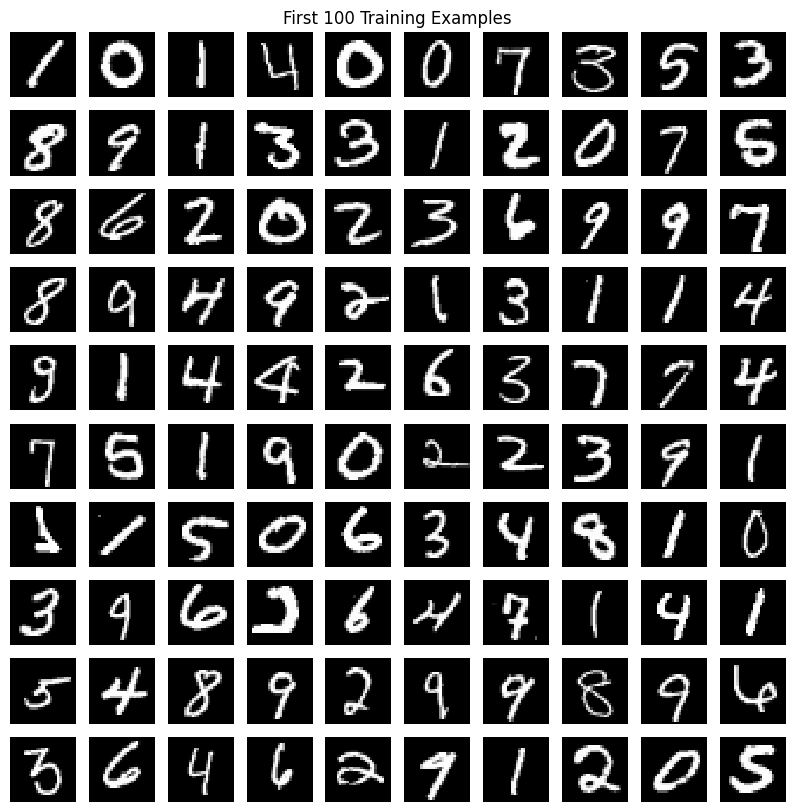

In [3]:
# Display the first 100 Training Examples

fig, ax = plt.subplots(figsize=(10,10))
plt.axis('off')
plt.title('First 100 Training Examples')

for i in range(100):
    fig.add_subplot(10,10,i+1)
    plt.imshow(train_df.iloc[i,1:].values.reshape(28,28),interpolation='nearest',cmap='gray')
    plt.axis('off')
plt.show()

In [4]:
# Process the data

X = train_df.copy()
y = train_df.pop('label')

features = list(X.columns[1:])

transformer = make_pipeline(
    MinMaxScaler(),
)

preprocessor = make_column_transformer(
    (transformer, features),
)

X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]
y_train = keras.utils.to_categorical(y_train, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')

In [7]:
# Define the model

model = Sequential([
    layers.Dense(784, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

Epoch 1/200
247/247 [==============================] - 2s 7ms/step - loss: 0.5499 - accuracy: 0.8287 - val_loss: 0.1898 - val_accuracy: 0.9450
Epoch 2/200
247/247 [==============================] - 2s 7ms/step - loss: 0.1914 - accuracy: 0.9480 - val_loss: 0.1451 - val_accuracy: 0.9603
Epoch 3/200
247/247 [==============================] - 2s 7ms/step - loss: 0.1541 - accuracy: 0.9575 - val_loss: 0.1312 - val_accuracy: 0.9630
Epoch 4/200
247/247 [==============================] - 2s 7ms/step - loss: 0.1235 - accuracy: 0.9655 - val_loss: 0.1164 - val_accuracy: 0.9678
Epoch 5/200
247/247 [==============================] - 2s 7ms/step - loss: 0.0974 - accuracy: 0.9726 - val_loss: 0.1089 - val_accuracy: 0.9719
Epoch 6/200
247/247 [==============================] - 2s 8ms/step - loss: 0.0866 - accuracy: 0.9765 - val_loss: 0.1278 - val_accuracy: 0.9685
Epoch 7/200
247/247 [==============================] - 2s 7ms/step - loss: 0.0735 - accuracy: 0.9789 - val_loss: 0.1183 - val_accuracy: 0.9703

<AxesSubplot: title={'center': 'Accuracy'}>

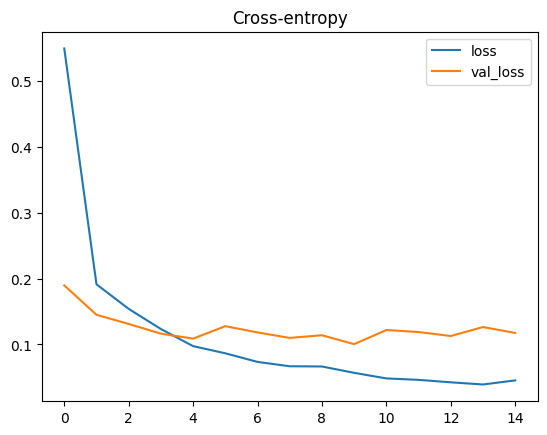

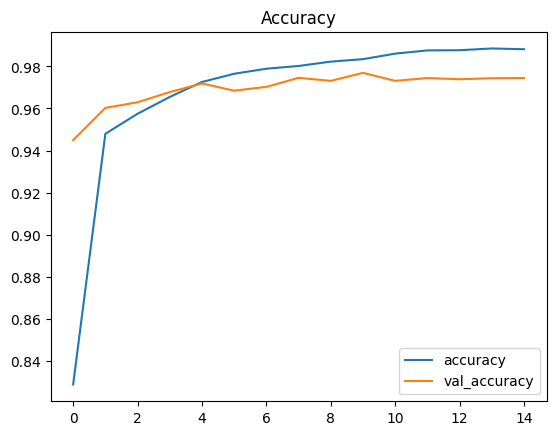

In [8]:
# Train the model

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=128,
    epochs=200,
    callbacks=[early_stopping],
)
score = model.evaluate(X_valid, y_valid, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [9]:
# Process the test data
X_test = test_df.copy()
features = list(test_df.columns)

transformer = make_pipeline(
    MinMaxScaler(),
)

preprocessor = make_column_transformer(
    (transformer, features),
)



X_test = preprocessor.fit_transform(X_test)

X_test = X_test.astype('float32')

In [10]:
# Make predictions with test data

y_pred = model.predict(X_test, batch_size=128, verbose=1, callbacks=early_stopping)
y_pred = [np.argmax(y_pred[i]) for i in range(y_pred.shape[0])]

219/219 [==============================] - 1s 2ms/step


In [11]:
# Preprare predictions for submission

predictions_df = pd.DataFrame(y_pred, columns=['Label'])
predictions_df.index=predictions_df.index+1

In [12]:
# Create submission file
predictions_df.to_csv('submission.csv', index=True, index_label='ImageId')